In [17]:
from evaluator import FiLMModelEvaluator
from model import FiLMModel
from baseline_concat_model import MLPModel
from utils import *
from dataset_unseen_compounds import SciplexDatasetUnseenPerturbations
import random
from sklearn.metrics import r2_score

import anndata as ad
import math

In [2]:
drugs_list = list(ad.read_h5ad("../data/sciplex/sciplex_preprocessed.h5ad").obs['product_name'].unique())

In [3]:
def split_list(lst):
    # Calculate the split sizes
    total_len = len(lst)
    split_70 = math.floor(total_len * 0.7)
    split_85 = math.floor(total_len * 0.85)

    # Split the list into three parts
    train = lst[:split_70]    # First 70% (training set)
    val = lst[split_70:split_85]   # Next 15% (validation set)
    test = lst[split_85:]     # Remaining 15% (test set)

    return train, val, test


random.shuffle(drugs_list)
train_drugs, validation_drugs, test_drugs = split_list(drugs_list)

test_drugs.extend(validation_drugs)

In [4]:
ad_path = "../data/sciplex/sciplex_preprocessed.h5ad"

dataset_train = SciplexDatasetUnseenPerturbations(ad_path, train_drugs, 10000)
dataset_validation = SciplexDatasetUnseenPerturbations(ad_path, validation_drugs, 10000)
dataset_test = SciplexDatasetUnseenPerturbations(ad_path, test_drugs, 10000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 571906/571906 [00:29<00:00, 19356.16it/s]


In [7]:
evalautor = FiLMModelEvaluator("../config/FiLM.yaml",FiLMModel, dataset_train, dataset_validation, dataset_test)
evalautor.train()
evalautor.test()
results = evalautor.get_test_results()
results_edistance = get_model_stats(results)

Begin training ...
Epoch 1/10
Iteration: 10 Test Loss: 0.44096052646636963 Avg. Validation Loss: 0.42762478282957367
Iteration: 20 Test Loss: 0.3526018261909485 Avg. Validation Loss: 0.34687056956869183
Iteration: 30 Test Loss: 0.31670480966567993 Avg. Validation Loss: 0.3142218752340837
Iteration: 40 Test Loss: 0.30247658491134644 Avg. Validation Loss: 0.299909256624453
Iteration: 50 Test Loss: 0.28917908668518066 Avg. Validation Loss: 0.28781136057593604
Iteration: 60 Test Loss: 0.27854374051094055 Avg. Validation Loss: 0.27641537604909955
Iteration: 70 Test Loss: 0.2671857476234436 Avg. Validation Loss: 0.26621954278512433
Iteration: 80 Test Loss: 0.2574591040611267 Avg. Validation Loss: 0.2561618739908392
Iteration: 90 Test Loss: 0.24775995314121246 Avg. Validation Loss: 0.24766968867995523
Iteration: 100 Test Loss: 0.24102677404880524 Avg. Validation Loss: 0.24085825862306537
Iteration: 110 Test Loss: 0.234635591506958 Avg. Validation Loss: 0.2345657136404153
Iteration: 120 Test L

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:01<00:00, 64.98it/s]


Testing completed. Results stored in 'self.test_results'.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:08<00:00,  6.63it/s]


Avg Pred Loss: 0.0802474593766505
Avg Null Loss: 0.09473329517698441
Avg Similarity Loss: 0.024595733051156688


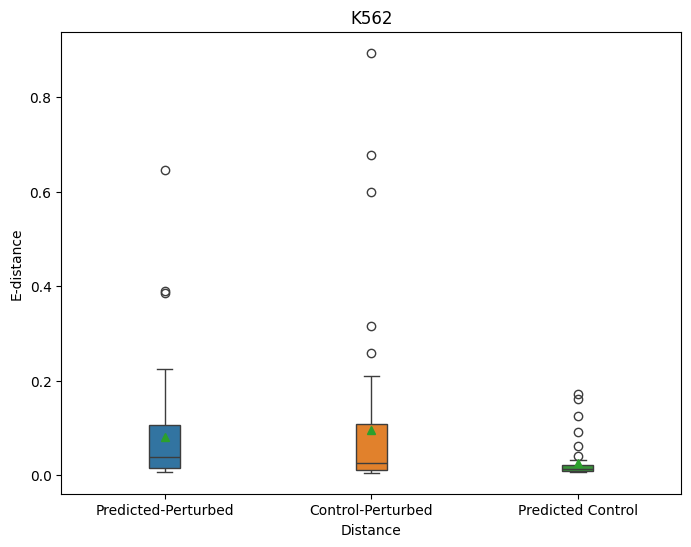

Avg Pred Loss: 0.0571635961844448
Avg Null Loss: 0.07255148334891959
Avg Similarity Loss: 0.02472454195899064


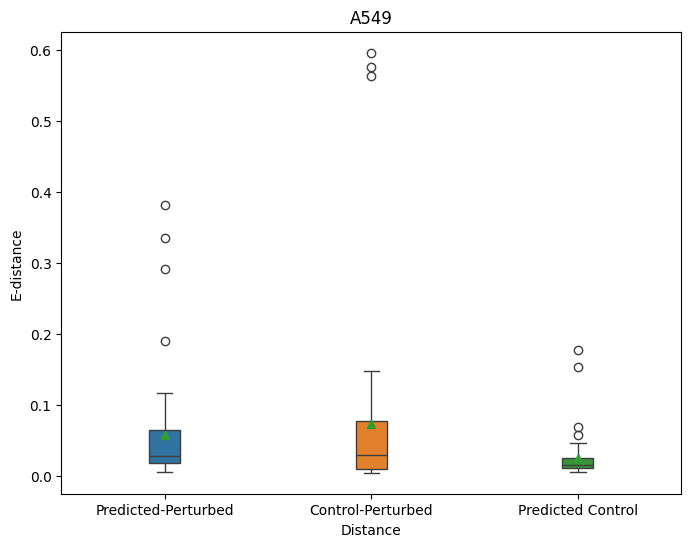

Avg Pred Loss: 0.08200427506935398
Avg Null Loss: 0.09345461701707244
Avg Similarity Loss: 0.03006001414829967


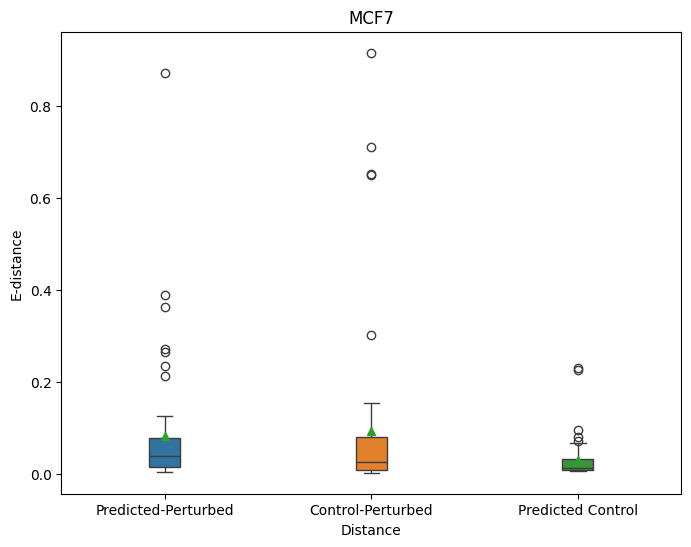

In [8]:
plot_results(results_edistance, "K562")
plot_results(results_edistance, "A549")
plot_results(results_edistance, "MCF7")

In [22]:
def get_model_performance(formatted_test_results):
    """
    Calculate R2 of model
    """

    r2_values = dict()

    for cell_type in formatted_test_results['cell_type'].unique():
        losses = list()

        df_subset = formatted_test_results[formatted_test_results['cell_type'] == cell_type]

        r2_per_cell = list()
        for i, row in df_subset.iterrows():

            emb_pert = np.array(row['pert_emb'])
            emb_pred = np.array(row['pred_emb'])

            
            r2 = r2_score(emb_pert, emb_pred)

            r2_per_cell.append(r2)

        r2_values[cell_type] = np.mean(r2_per_cell)

    return r2_values

def get_null_baseline(formatted_test_results):
    """
    Calculate R2 of model
    """

    r2_values = dict()

    for cell_type in formatted_test_results['cell_type'].unique():
        losses = list()

        df_subset = formatted_test_results[formatted_test_results['cell_type'] == cell_type]

        r2_per_cell = list()
        for i, row in df_subset.iterrows():

            emb_pert = np.array(row['pert_emb'])
            emb_ctrl = np.array(row['ctrl_emb'])

            
            r2 = r2_score(emb_pert, emb_ctrl)

            r2_per_cell.append(r2)

        r2_values[cell_type] = np.mean(r2_per_cell)

    return r2_values

In [19]:
get_model_performance(results)

{'A549': np.float64(0.6827784639199663),
 'K562': np.float64(0.6058224730629433),
 'MCF7': np.float64(0.6858216292592889)}

In [23]:
get_null_baseline(results)

{'A549': np.float64(0.3847266145591889),
 'K562': np.float64(0.24794523295364967),
 'MCF7': np.float64(0.4047743360360268)}

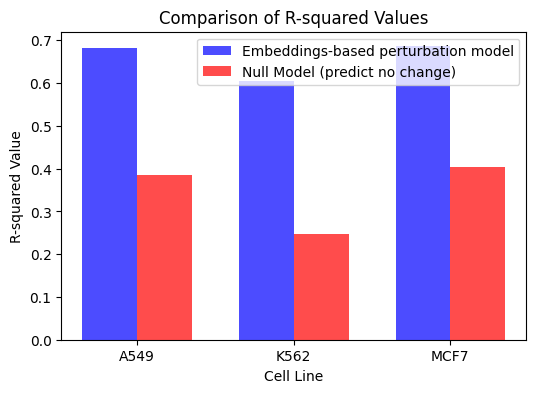

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Data
r2_set1 = {'A549': np.float64(0.6827784639199663),
           'K562': np.float64(0.6058224730629433),
           'MCF7': np.float64(0.6858216292592889)}

r2_set2 = {'A549': np.float64(0.3847266145591889),
           'K562': np.float64(0.24794523295364967),
           'MCF7': np.float64(0.4047743360360268)}

# Convert to lists
categories = list(r2_set1.keys())  # ['A549', 'K562', 'MCF7']
values1 = list(r2_set1.values())
values2 = list(r2_set2.values())

# Bar width and positions
x = np.arange(len(categories))  # Position of groups
width = 0.35  # Width of bars

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
bars1 = ax.bar(x - width/2, values1, width, label='Embeddings-based perturbation model', color='b', alpha=0.7)
bars2 = ax.bar(x + width/2, values2, width, label='Null Model (predict no change)', color='r', alpha=0.7)

# Labels and title
ax.set_xlabel('Cell Line')
ax.set_ylabel('R-squared Value')
ax.set_title('Comparison of R-squared Values')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Show plot
plt.show()

In [27]:
evalautor_baseline = FiLMModelEvaluator("../config/baseline.yaml",MLPModel, dataset_train, dataset_validation, dataset_test)
evalautor_baseline.train()
evalautor_baseline.test()
results = evalautor_baseline.get_test_results()
results_edistance = get_model_stats(results)

Begin training ...
Epoch 1/5
Iteration: 10 Test Loss: 0.37038499116897583 Avg. Validation Loss: 0.3670993880792098
Iteration: 20 Test Loss: 0.3409397006034851 Avg. Validation Loss: 0.3398102440617301
Iteration: 30 Test Loss: 0.32894137501716614 Avg. Validation Loss: 0.3261534237500393
Iteration: 40 Test Loss: 0.31682488322257996 Avg. Validation Loss: 0.31574936256264197
Iteration: 50 Test Loss: 0.3080478310585022 Avg. Validation Loss: 0.30744002262751263
Iteration: 60 Test Loss: 0.3008888363838196 Avg. Validation Loss: 0.30004334088527795
Iteration: 70 Test Loss: 0.2934991419315338 Avg. Validation Loss: 0.2931144860657779
Iteration: 80 Test Loss: 0.28880172967910767 Avg. Validation Loss: 0.2882990674539046
Iteration: 90 Test Loss: 0.2837897539138794 Avg. Validation Loss: 0.2832798750111551
Iteration: 100 Test Loss: 0.27911075949668884 Avg. Validation Loss: 0.27885474400086835
Iteration: 110 Test Loss: 0.2731339931488037 Avg. Validation Loss: 0.27412001111290674
Iteration: 120 Test Loss

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:01<00:00, 50.72it/s]


Testing completed. Results stored in 'self.test_results'.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:02<00:00, 22.20it/s]


In [28]:
get_model_performance(results)

{'MCF7': np.float64(0.6781501758369699),
 'A549': np.float64(0.6642606446086943),
 'K562': np.float64(0.5773789449480968)}

Avg Pred Loss: 0.11837954845481455
Avg Null Loss: 0.09075473485089022
Avg Similarity Loss: 0.10378766494007666


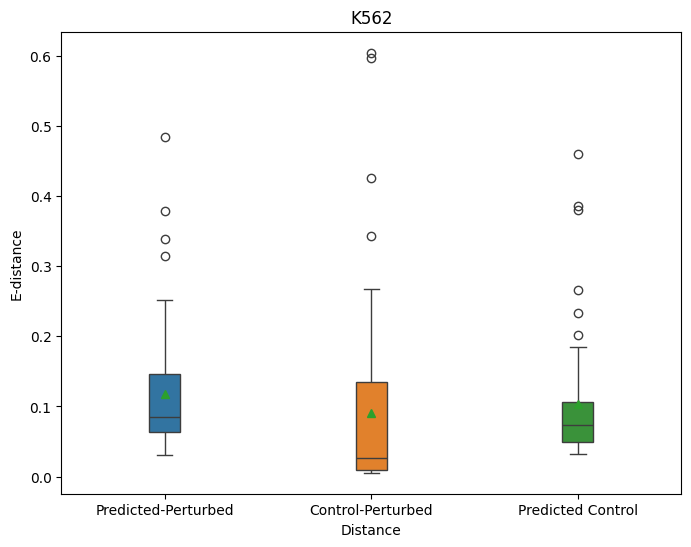

Avg Pred Loss: 0.08455981809418775
Avg Null Loss: 0.07772764163168051
Avg Similarity Loss: 0.06794385161337663


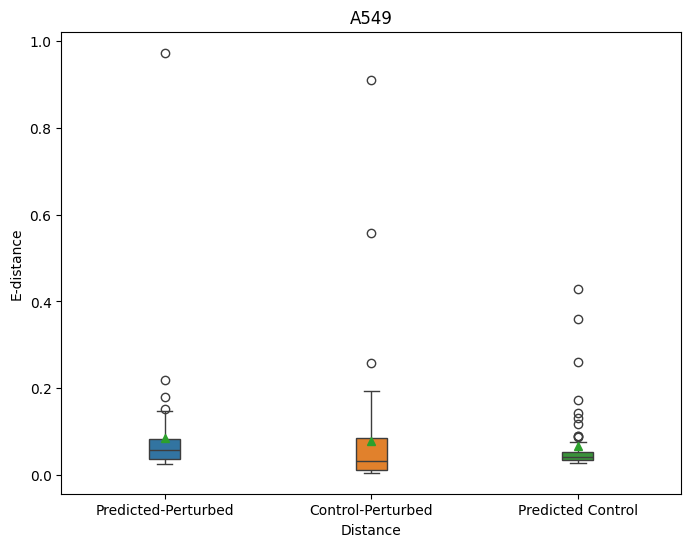

Avg Pred Loss: 0.08878929252897862
Avg Null Loss: 0.0764933059020324
Avg Similarity Loss: 0.07946737764235937


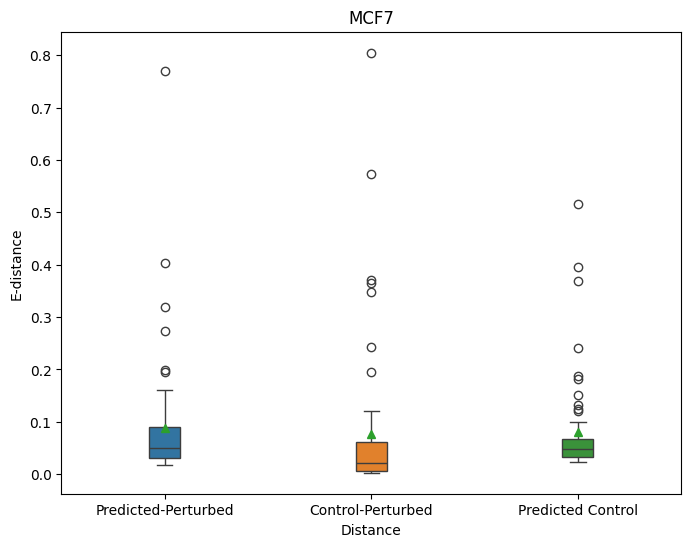

In [8]:
plot_results(results, "K562")
plot_results(results, "A549")
plot_results(results, "MCF7")